In [50]:
import numpy as np
import tensorflow as tf
import cv2

In [51]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [52]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars=
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


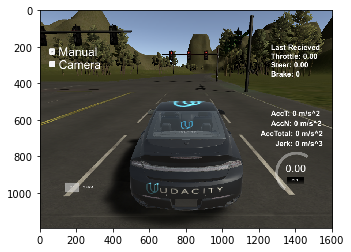

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline


def normalize(img, beta=255):
    cv2.normalize(img, img, alpha=0, beta=beta, norm_type=cv2.NORM_MINMAX)


def plot_inline(images, titles, figsize=(24, 9)):
    assert len(images) == len(titles)
    f, axs = plt.subplots(1, len(images), figsize=figsize)
    f.tight_layout()
    for i in range(0, len(images)):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(titles[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


test_img_1 = cv2.imread('tmp/0.png')
test_img_1 = cv2.cvtColor(test_img_1, cv2.COLOR_BGR2RGB)
normalize(test_img_1)

plt.imshow(test_img_1)

In [56]:
from scipy.ndimage.measurements import label


def create_heatmap(image, windows, thresh=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels


def search_windows(img, windows, sess, x, predictions, probabilities):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        
#         pred_nums, _ = sess.run([predictions, probabilities], feed_dict={x: [test_img]})
        pred_nums, sf = sess.run([predictions, probabilities], feed_dict={x: [test_img]})
        print('Prediction {}'.format(pred_nums))
        if len(pred_nums) > 0 and pred_nums[0] == 1:
            on_windows.append(window)
            
    return on_windows


def process_image(image, sess, x, predictions, probabilities):
    draw_image = np.copy(image)
    draw_image = draw_image.astype(np.float32)/255

    y_min = 0
    y_max = 200
    y_start_stop = [y_min, y_max]

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(24,24), xy_overlap=(0.5, 0.5))

    y_min = 150
    y_max = 300
    y_start_stop = [y_min, y_max]

    windows.extend(
        slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(32,32), xy_overlap=(0.5, 0.5))
    )

    y_min = 250
    y_max = 500
    y_start_stop = [y_min, y_max]

    windows.extend(
        slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64,64), xy_overlap=(0.5, 0.5))
    )
    
    hot_windows = search_windows(draw_image, windows, sess, x, predictions, probabilities)                       

    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    labels = create_heatmap(image, hot_windows)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('models/detect/tf_lenet.tf.meta')
    saver.restore(sess, tf.train.latest_checkpoint('models/detect'))

    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x_value:0')
    predictions = graph.get_tensor_by_name('predictions:0')
    probabilities = graph.get_tensor_by_name('Softmax:0')

    res = process_image(test_img_1, sess, x, predictions, probabilities)
    
plt.imshow(res)

INFO:tensorflow:Restoring parameters from models/detect/tf_lenet.tf


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [3] rhs shape= [2]
	 [[Node: save/Assign_29 = Assign[T=DT_FLOAT, _class=["loc:@Variable_9"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_9/Adam_1, save/RestoreV2_29)]]

Caused by op 'save/Assign_29', defined at:
  File "/Users/anechaev/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/anechaev/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-26fee0d1b171>", line 65, in <module>
    saver = tf.train.import_meta_graph('models/classify/lenet.tf.meta')
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1838, in import_meta_graph
    **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 660, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 316, in new_func
    return func(*args, **kwargs)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 548, in import_graph_def
    op_def=op_def)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/Users/anechaev/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1617, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [3] rhs shape= [2]
	 [[Node: save/Assign_29 = Assign[T=DT_FLOAT, _class=["loc:@Variable_9"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_9/Adam_1, save/RestoreV2_29)]]
